In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, TimeDistributed
from keras.models import load_model, model_from_json

# matplotlib theme
from jupyterthemes import jtplot
jtplot.style()

Using TensorFlow backend.


The following code snippet reads a CSV file of Trump's tweets. Tweets are "cleaned up" of "noise", and all tweets over 180 characters or under 50 are excluded. 

In [2]:
df = pd.read_csv('trump.csv') # might need to change location if on Floydhub
df = df[df.is_retweet=='false']
df.text = df.text.str.lower()
df.text = df.text.str.replace(r'http[\w:/\.]+','') # remove urls
df.text = df.text.str.replace(r'[^!\'"#$%&\()*+,-./:;<=>?@_’`{|}~\w\s]',' ') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df = df[[len(t)<180 for t in df.text.values]]
df = df[[len(t)>50 for t in df.text.values]]
df.head()

,source,text,created_at,favorite_count,is_retweet,id_str
0,Twitter for iPhone,i think senator blumenthal should take a nice ...,08-07-2017 20:48:54,61446,false,8.946617e+17
1,Twitter for iPhone,how much longer will the failing nytimes with ...,08-07-2017 20:39:46,42235,false,8.946594e+17
2,Twitter for iPhone,the fake news media will not talk about the im...,08-07-2017 20:15:18,45050,false,8.946532e+17
4,Twitter for iPhone,on #purpleheartday i thank all the brave men a...,08-07-2017 18:03:42,48472,false,8.946201e+17
5,Twitter for iPhone,...conquests how brave he was and it was all a...,08-07-2017 12:01:20,59253,false,8.945289e+17


We pad each tweet by adding a GO token before and an END token after.

In [3]:
trump_tweets = [text for text in df.text.values[::-1]]
trump_tweets[:5]

['be sure to tune in and watch donald trump on late night with david letterman as he presents the top ten list tonight!',
 'donald trump will be appearing on the view tomorrow morning to discuss celebrity apprentice and his new book think like a champion!',
 'donald trump reads top ten financial tips on late show with david letterman: - very funny!',
 'new blog post: celebrity apprentice finale and lessons learned along the way: ',
 'my persona will never be that of a wallflower - i’d rather build walls than cling to them --donald j. trump']

In [4]:
all_tweets = ''.join(trump_tweets)
char2int = dict(zip(set(all_tweets), range(len(set(all_tweets)))))
char2int['<END>'] = len(char2int)
char2int['<GO>'] = len(char2int)
char2int['<PAD>'] = len(char2int)
int2char = dict(zip(char2int.values(), char2int.keys()))

You can see a histogram of the distribution of tweet lengths in our database.

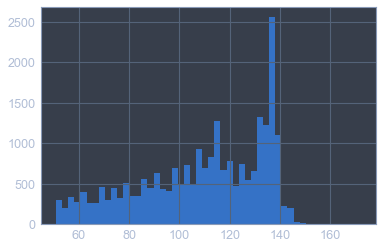

In [5]:
text_num = [[char2int['<GO>']]+[char2int[c] for c in tweet]+ [char2int['<END>']] for tweet in trump_tweets]

plt.hist([len(t) for t in trump_tweets],50)
plt.show()

Train sentences

In [6]:
len_vocab = len(char2int)
sentence_len = 40

num_examples = 0
for tweet in text_num:
    num_examples += len(tweet)-sentence_len

x = np.zeros((num_examples, sentence_len))
y = np.zeros((num_examples, sentence_len))

k = 0
for tweet in text_num:
    for i in range(len(tweet)-sentence_len):
        x[k,:] = np.array(tweet[i:i+sentence_len])
        y[k,:] = np.array(tweet[i+1:i+sentence_len+1])
        k += 1
        
y = y.reshape(y.shape+(1,))

In [8]:
print(x.shape)
print(y.shape)
print(df.shape)
print(len(text_num))

(1693437, 40)
(1693437, 40, 1)
(23902, 6)
23902


Many to Many LSTM

In [14]:
hidden_size = 64
vocabulary = len(char2int)
model = Sequential()
# TODO: create the model
# 1. Have an embedding layer for each character
emb = Embedding(vocabulary, hidden_size)
# 2. Put them into an LSTM with say 64 hidden units, but return all hidden states (return_sequences=True)
model.add(emb)
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
# 3. Take all those hidden states and connect them to a Dense layer
#    - Syntax is TimeDistributed(Dense(....))
#    - What are the number of units for Dense, what is the activation?
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          5440      
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 85)          5525      
_________________________________________________________________
activation_2 (Activation)    (None, None, 85)          0         
Total params: 110,037
Trainable params: 110,037
Non-trainable params: 0
_________________________________________________________________


Pay special attention to how the probabilites are taken. p is of shape (1, sequence_len, len(char2int)) where len(char2int) is the number of available characters. The 1 is there because we are only predicting one feature, y. We are only concerned about the last prediction probability of the sequence. This is due to the fact that all other letters have already been appended. Hence we predict a letter from the distribution p[0][-1].

Why did we keep appending to the sequence and predicting? Why not use simply the last letter. If we were to do this, we would lose information that comes from the previous letter via the hidden state and cell memory. Keep in mind that each LSTM unit has 3 inputs, the x, the hidden state, and the cell memory.

Also important to notice that the Cell Memory is not used in connecting to the Dense layer, only the hidden state.

In [16]:
n_epochs = 2
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(100):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=128, epochs=1)

<GO>o!mtnere rhcanglnaie .iros dt e mtadrh ekinen d iet rehf r-geoeeek gwtia yoscetm ptmiratahl hloniyo
Epoch 1/1
1693437/1693437 [==============================] - 2047s 1ms/step - loss: 2.0284
<GO>vonis @colubctumors inspiring to have to the waltersions can't get subate sometruttersing counry- o
Epoch 1/1
1693437/1693437 [==============================] - 2149s 1ms/step - loss: 1.5213
<GO>new dead but you would hake him a great to be sweet that i love it i've happennl not prosport' in j
Epoch 1/1
1693437/1693437 [==============================] - 2090s 1ms/step - loss: 1.4505


**Generate 30 random Trumps' tweets**

In [18]:
for j in range(30):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(150):
        sentence.append(int2char[letter[-1]])
        if sentence[-1]=='<END>':
            break
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])

    print(''.join(sentence))
    print('='*100)

<GO>later detaken crovans for door on strong attack cromoss rapoling to be the creatics big part you returns fia and jopkend lied’ lock tonight a fact of
<GO>it that don't be only back of giving @mittromney’s @apprenticenbc @trump2016 @realdonaldtrump perfanner) will be spentged record. that's the the prob
<GO>@cakeswotlaveratic to us in out #nreenwating 10 mind says libis doesn't can be because we has 're bagzer that is #imandrising to make our political a
<GO>? the destroying forward. it by @realdonaldtrump can sound the great first rapomo to donaldmreatly speech building roberbills at someinty debt at loa
<GO>inditique statements (&amp; isnerviewnl forguration: #donly dishones. make the ratings.<END>
<GO>@elangervhirsk man's foreign-weipo must be eire in watching smren sadis when to europe in better from obama's out of @cnn acrunk to have very impenit
<GO>@ngainewl @raknewax #sptorruding #yestate lines source against follly last night: "786 has got things wonderful returns for opens

Generate  tweets startwith ""white supremacists are ""

Feel free to change the starting sentence as you please. But remember simple letters.



In [20]:
letter = [char2int[letter] for letter in "white supremacists are "]
sentence = [int2char[l] for l in letter]

for i in range(150):
    if sentence[-1]=='<END>':
        break
    p = model.predict(np.array(letter)[None,:])
    letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    sentence.append(int2char[letter[-1]])
print(''.join(sentence))

white supremacists are never beggis house to save amnigulate should socigment is politicizes 12 goving @arseraluels #celebrityapprentice. @trumpshithy polls and quarter into


### Remarks
The results are not very convincing... let's train the model further and reiterate

In [21]:
n_epochs = 1
for i in range(n_epochs+1):
    sentence = []
    letter = [char2int['<GO>']] #choose a random letter
    for i in range(100):
        sentence.append(int2char[letter[-1]])
        p = model.predict(np.array(letter)[None,:])
        letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    print(''.join(sentence))
    print('='*100)
    if i!=n_epochs:
        model.fit(x,y, batch_size=128, epochs=1)

<GO>declineur follusive at 1/31 the @andact should be golf leader me one that when the right’s candidat
Epoch 1/1
1693437/1693437 [==============================] - 2044s 1ms/step - loss: 1.4182
<GO>make news of iraq is doing how modera_scars. he is discania on city magniz if over the horrorir in 
Epoch 1/1
1693437/1693437 [==============================] - 1920s 1ms/step - loss: 1.3987


In [28]:
letter = [char2int[letter] for letter in "hillary "]
sentence = [int2char[l] for l in letter]

for i in range(150):
    if sentence[-1]=='<END>':
        break
    p = model.predict(np.array(letter)[None,:])
    letter.append(np.random.choice(len(char2int),1,p=p[0][-1])[0])
    sentence.append(int2char[letter[-1]])
print(''.join(sentence))

hillary majority attack couplyy stlethet. grasspost "the some "sense; @venymanacare our cruz you get @realdonaldtrump great toastic on the @send are going. al


Not very convincing either... I will submit for now but train the model again and maybe resubmit if I get something more interesting...